In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
%matplotlib inline

# Loading Dataset

In [3]:


# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is not None:
            images.append(img)
    return np.array(images)

# Function to add noise to images
def add_noise(images):
    noisy_images = images + np.random.normal(loc=0, scale=25, size=images.shape)  # Adding Gaussian noise
    noisy_images = np.clip(noisy_images, 0, 255)  # Clip pixel values to [0, 255]
    return noisy_images.astype('uint8')

# Load clean images
clean_images = load_images_from_folder(os.path.abspath(os.getcwd()) +  "/crop/images")
# Add noise to images
noisy_images = add_noise(clean_images)


# Define autoencoder architecture

In [4]:
def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)
    encoded = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    encoded = layers.MaxPooling2D((5, 5), padding='same')(encoded)
    encoded = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    decoded = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(decoded)
    decoded = layers.UpSampling2D((5, 5))(decoded)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
    autoencoder = models.Model(input_img, decoded)
    return autoencoder



# Normalize pixel values


In [5]:
noisy_images = noisy_images / 255.0
clean_images = clean_images / 255.0



# Train-test split


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(clean_images, clean_images, test_size=0.2, random_state=42)
print('Training data shapes: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Testing data shapes: X=%s, y=%s' % (x_test.shape, y_test.shape))
x_train.shape

Training data shapes: X=(1100, 250, 250), y=(1100, 250, 250)
Testing data shapes: X=(276, 250, 250), y=(276, 250, 250)


(1100, 250, 250)


# Build and compile the autoencoder


In [7]:
input_shape = (x_train.shape[1], x_train.shape[2], 1)
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 250, 250, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 250, 250, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 250, 250, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 250, 250, 1)    │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,265 (28.38 KB)

 Trainable params: 7,265 (28.38 KB)

 Non-trainable params: 0 (0.00 B)

# Train the autoencoder with early stopping


In [14]:

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


training_history = autoencoder.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 270ms/step - loss: 0.1370 - val_loss: 0.0539
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - loss: 0.0473 - val_loss: 0.0143
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - loss: 0.0116 - val_loss: 0.0058
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/ste

In [37]:
training_history.history.keys()

dict_keys(['loss', 'val_loss'])

# Visualisation of the Training


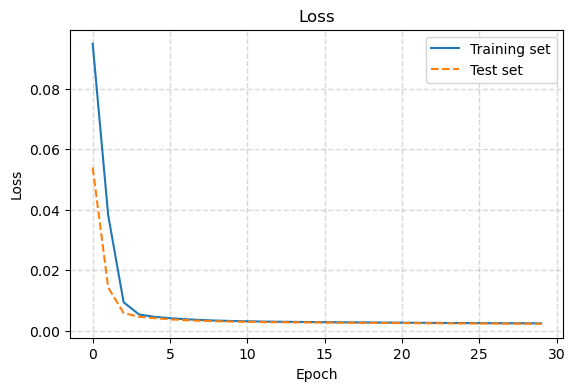

In [15]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)



    plt.show()

# Grafische Darstellung der Trainings-Historie
render_training_history(training_history)

# Load the saved autoencoder model


In [ ]:
from tensorflow.keras.models import load_model
loaded_autoencoder = load_model('autoencoder_model.keras')


# Denoising images


In [16]:
new_images = load_images_from_folder(os.path.abspath(os.getcwd()) +  "/crop/images")
new_images = new_images / 255.0
denoised_images = autoencoder.predict(new_images)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step



# Display results


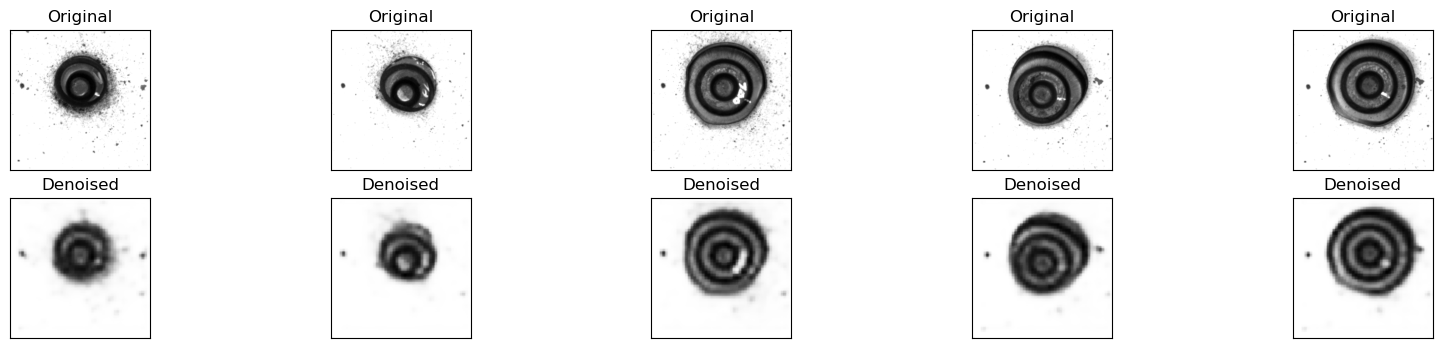

In [17]:
import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(new_images[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display denoised images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denoised_images[i])
    plt.title("Denoised")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# save denoised images


In [18]:
output_folder = 'noise/denoised_images_folder_v3'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i, image in enumerate(denoised_images):
    filename = os.path.join(output_folder, f'denoised_image_{i}.png')
    cv2.imwrite(filename, cv2.cvtColor(image * 255, cv2.COLOR_RGB2BGR))

# save autoencoder


In [19]:
autoencoder.save('autoencoder10_16_model.keras')

In [13]:
import numpy as np
from scipy.stats import mode

# Example NumPy array
arr = np.array([1, 2, 3, 4, 2, 2, 3, 3, 3, 5, 5])

# Find the mode
result = mode(arr)

result.mode
#print("Mode:", result.mode)
#print("Number of occurrences:", result.count[0])

3